#Importing libraries

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install TensorFlow
#!{sys.executable} -m pip install keras
#!{sys.executable} -m pip install peewee
#!{sys.executable} -m pip uninstall pymysql
#!{sys.executable} -m pip uninstall mysqlclient
#!{sys.executable} echo y | {sys.executable} -m pip uninstall pymysql
#!{sys.executable} -m pip install playhouse.mysql_ext

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement playhouse.mysql_ext
ERROR: No matching distribution found for playhouse.mysql_ext


In [19]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

import sklearn as skl
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn import model_selection

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

#file management
import glob
import os

#import date
from datetime import date

#import peewee
from peewee import *

#importing unique IDs
import uuid

In [27]:
#For now, you can log in to Maartje's username. Later, this should be changed to separate users.
name = 'maartjehuveneers'
pw = 'p4RwxJCchw7Ljqhv'

#Setting up database
db = MySQLDatabase('HorsingAround', user=name, password=pw,
                         host='www.jacobkamminga.nl', port=3306)

class Experiment(Model):
    key = IntegerField()
    username = TextField()
    date = DateField()
    accuracy_experiment = DoubleField()
    fscore = DoubleField()
    mcc = DoubleField()
    settings = TextField()
    class Meta:
        database = db
    
class Activity(Model):
    key = IntegerField()
    accuracy_activity = DoubleField()
    recall = DoubleField()
    specificity = DoubleField()
    precision = DoubleField()
    TP = IntegerField()
    TN = IntegerField()
    FP = IntegerField()
    FN = IntegerField()
    class Meta:
        database = db
    
    
db.connect()

True

In [30]:
#The next line is used to create a new table in the database, don't uncomment this unless needed. Otherwise we make a new table every time we run the program

#db.create_tables([Experiment, Activity])

In [34]:
uid = uuid.uuid1()
print(uid)
Experiment.create(key=uid, username=name, date=date.today(), accuracy_experiment=97.75, fscore=63.2, mcc=-0.3, settings='second trial settings')
Activity.create(key=uid, accuracy_experiment=84.35, recall=32.2, specificity=22.33, precision=29.32, TP=233, TN=22, FP=21, FN=333)

1d253c66-8cb0-11eb-bd4a-02420a0001ca


<Experiment: 2>

Setting up some constants

In [35]:
#printing all results
#printing information of all rows
query = Experiment.select().dicts()
for q in query:
    print(q)
    
query = Activity.select().dicts()
for q in query:
    print(q)

#printing information about specific rows
#query2 = Result.select()
#for q in query2:
#    print(q.key, q.username, q.date, q.accuracy, q.fscore, q.mcc, q.settings)

{'id': 1, 'key': 22, 'username': 'maartjehuveneers', 'date': datetime.date(2021, 3, 24), 'accuracy_experiment': 97.75, 'fscore': 63.2, 'mcc': -0.3, 'settings': 'second trial settings'}
{'id': 2, 'key': 2147483647, 'username': 'maartjehuveneers', 'date': datetime.date(2021, 3, 24), 'accuracy_experiment': 97.75, 'fscore': 63.2, 'mcc': -0.3, 'settings': 'second trial settings'}
{'id': 1, 'key': 22, 'accuracy_activity': 0.0, 'recall': 32.2, 'specificity': 22.33, 'precision': 29.32, 'TP': 233, 'TN': 22, 'FP': 21, 'FN': 333}


In [51]:
#searching for an experiment and printing its results
#insert experiment key below as variable
experiment_key = 22

query = Experiment.select().where(Experiment.key == experiment_key).dicts()
for exp in query:
    print(exp)
    
query = Activity.select().where(Activity.key == experiment_key).dicts()
for exp in query:
    print(exp)

{'id': 1, 'key': 22, 'username': 'maartjehuveneers', 'date': datetime.date(2021, 3, 24), 'accuracy_experiment': 97.75, 'fscore': 63.2, 'mcc': -0.3, 'settings': 'second trial settings'}
{'id': 1, 'key': 22, 'accuracy_activity': 0.0, 'recall': 32.2, 'specificity': 22.33, 'precision': 29.32, 'TP': 233, 'TN': 22, 'FP': 21, 'FN': 333}


In [5]:
#Some styling
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('ggplot')

#Label encoder used to get a numeric representation of a label
le = preprocessing.LabelEncoder()

#The activities
LABELS = ['standing',
          'walking-natural',
          'walking-rider',
          'trotting-natural',
          'trotting-rider',
          'running-natural',
          'running-rider',
          'jumping',
          'grazing',
          'eating',
          'head shake',
          'shaking',
          'scratch-biting',
          'rubbing',
          'fighting',
          'rolling',
          'scared']

#Sliding windows
TIME_PERIODS = 80
STEP_DISTANCE = 40

#Datasets
FILES = sorted(glob.glob('horse_data/*.csv'))

#Set up dataframe

In [6]:
REMOVE_COLUMNS = ['Mx', 'My', 'Mz','A3D','G3D','M3D'] #Add columns to drop from dataframe

def loadDataFrame(files):
    """
    Simple function to set up dataframe and initial clean-up of the data
    files: path to files
    returns: combined dataframe of all files
    """
    df = pd.concat((pd.read_csv(file) for file in files))
    df.drop(REMOVE_COLUMNS, axis=1, inplace=True)
    df['ActivityEncoded'] = le.fit_transform(df['label'].values.ravel())
    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


df = loadDataFrame(FILES)
df.head(10)

,Ax,Ay,Az,Gx,Gy,Gz,datetime,label,segment,ActivityEncoded
0,6.5,-1.2,3.3,-12.8,54.2,-3.4,2018-06-14 20:06:48.0988,walking-natural,13935,16
1,6.6,-0.5,3.2,1.7,58.2,-6.8,2018-06-14 20:06:48.1088,walking-natural,13935,16
2,6.7,0.8,3.5,26.2,60.6,-8.1,2018-06-14 20:06:48.1188,walking-natural,13935,16
3,6.8,2.1,3.8,48.7,58.9,-8.8,2018-06-14 20:06:48.1288,walking-natural,13935,16
4,6.8,3.2,4.2,60.0,55.4,-9.1,2018-06-14 20:06:48.1388,walking-natural,13935,16
5,6.8,3.9,4.7,60.2,50.0,-8.2,2018-06-14 20:06:48.1488,walking-natural,13935,16
6,6.7,3.5,5.3,50.8,44.5,-6.9,2018-06-14 20:06:48.1588,walking-natural,13935,16
7,7.2,2.6,5.1,31.4,42.3,-4.8,2018-06-14 20:06:48.1688,walking-natural,13935,16
8,7.6,1.6,4.3,2.9,43.5,-2.3,2018-06-14 20:06:48.1788,walking-natural,13935,16
9,7.7,0.8,4.0,-18.1,48.6,1.5,2018-06-14 20:06:48.1888,walking-natural,13935,16


#Plot data composition

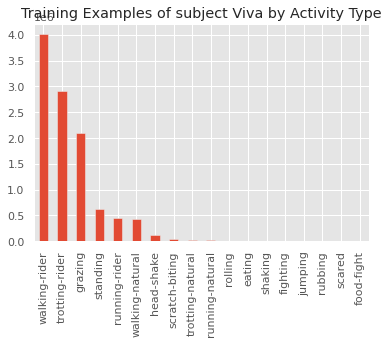

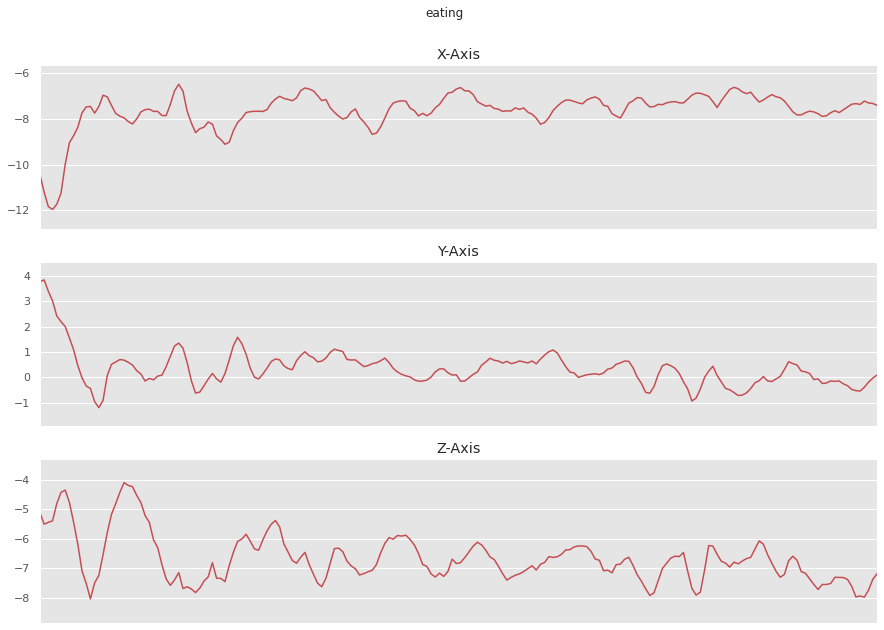

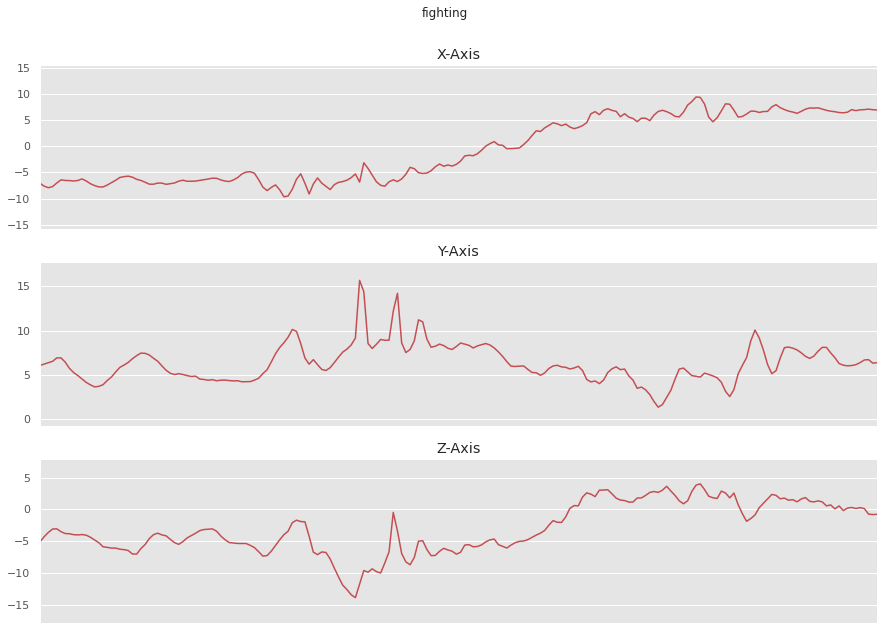

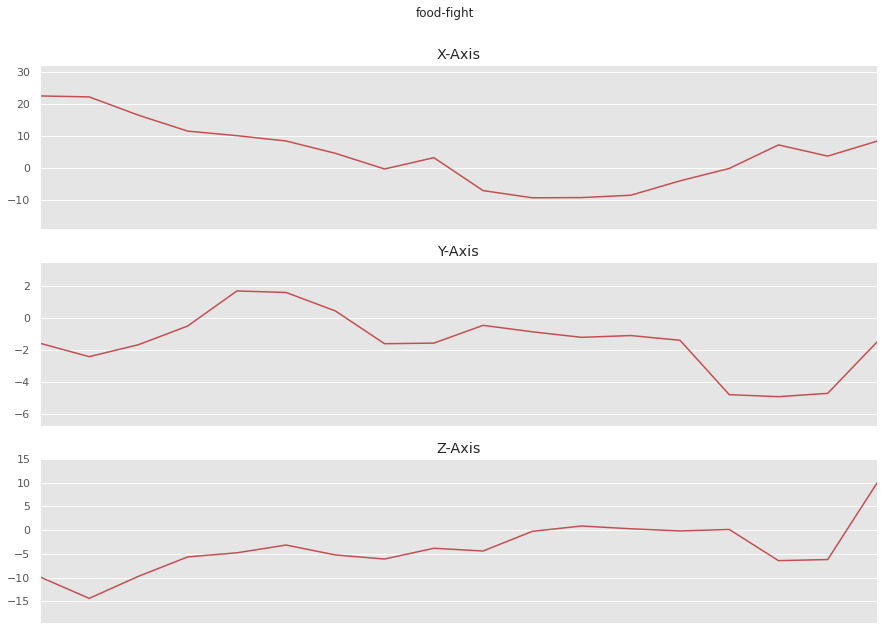

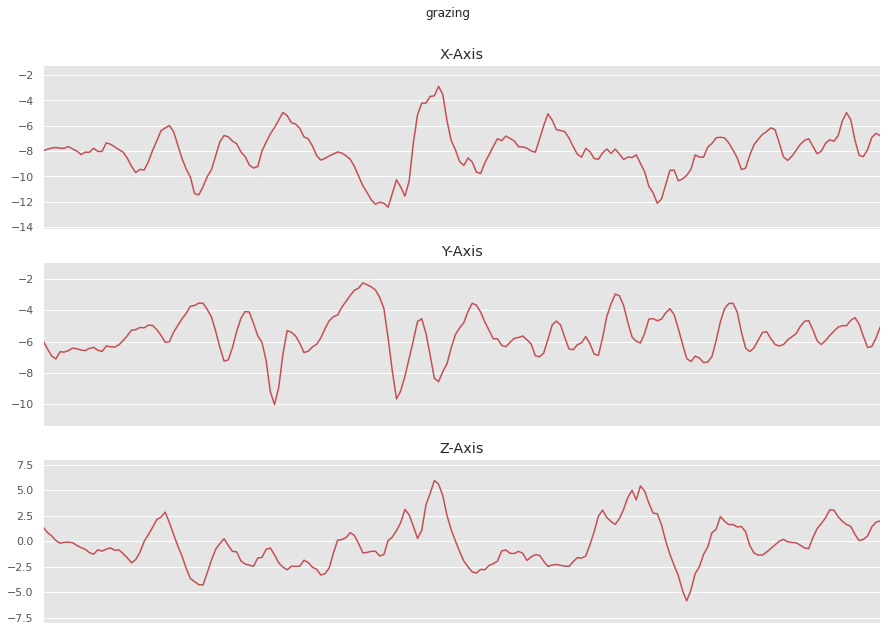

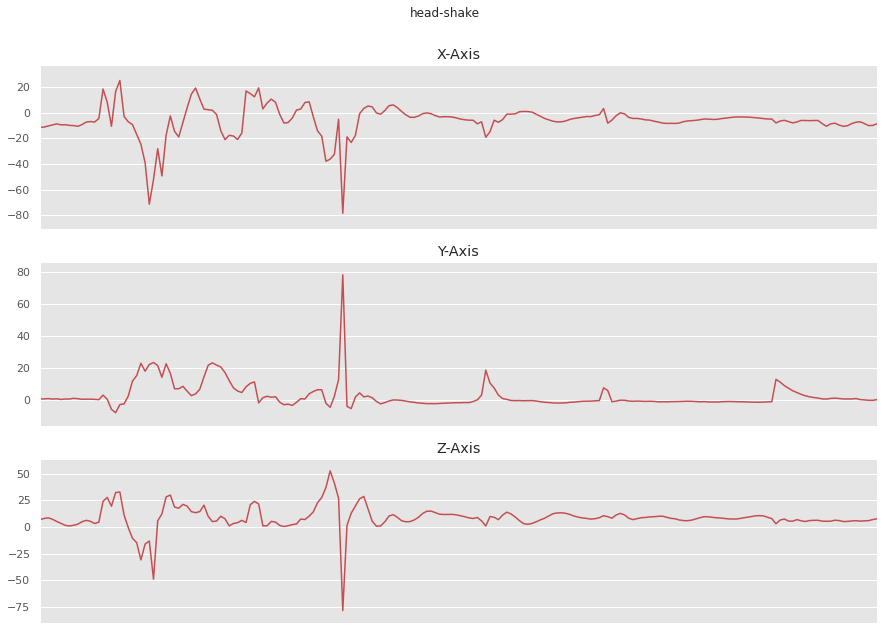

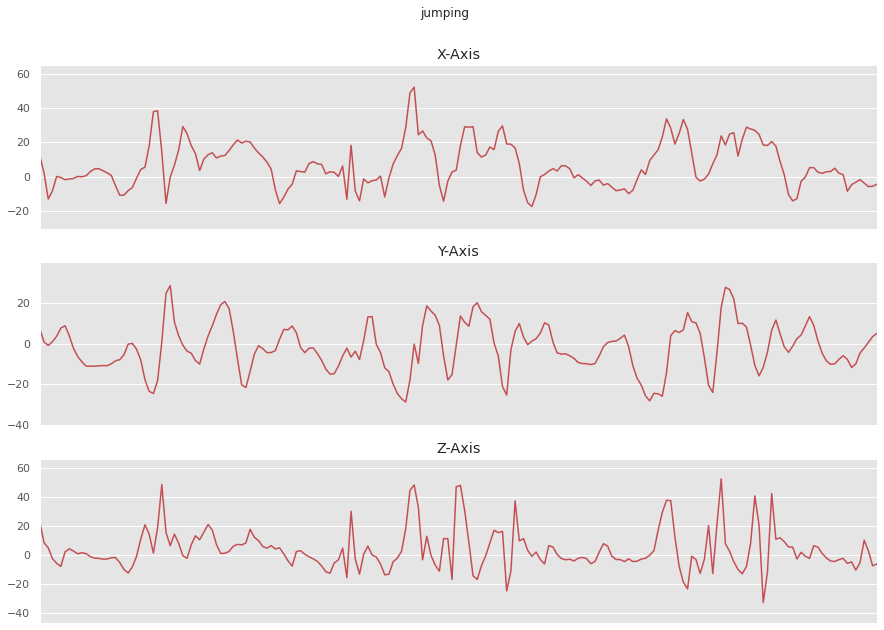

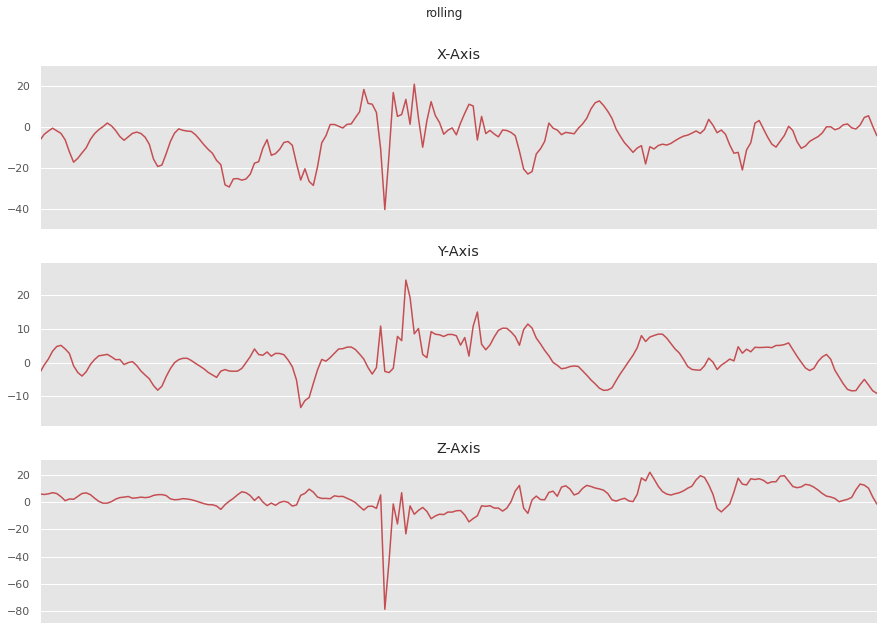

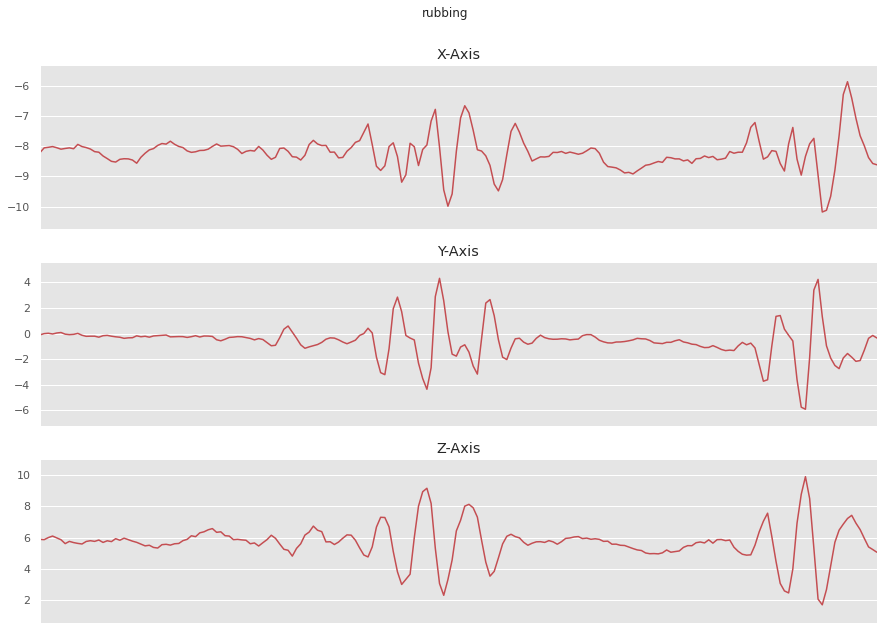

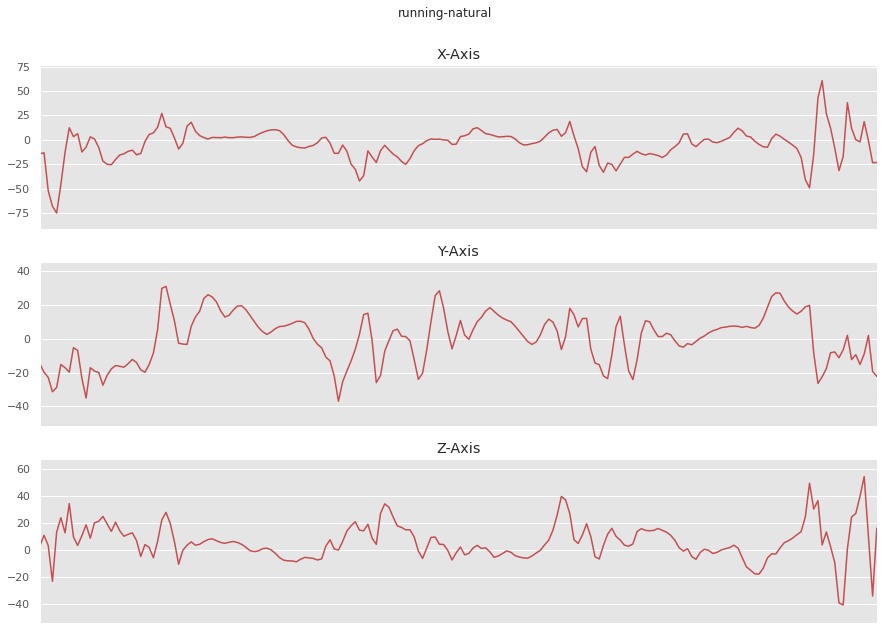

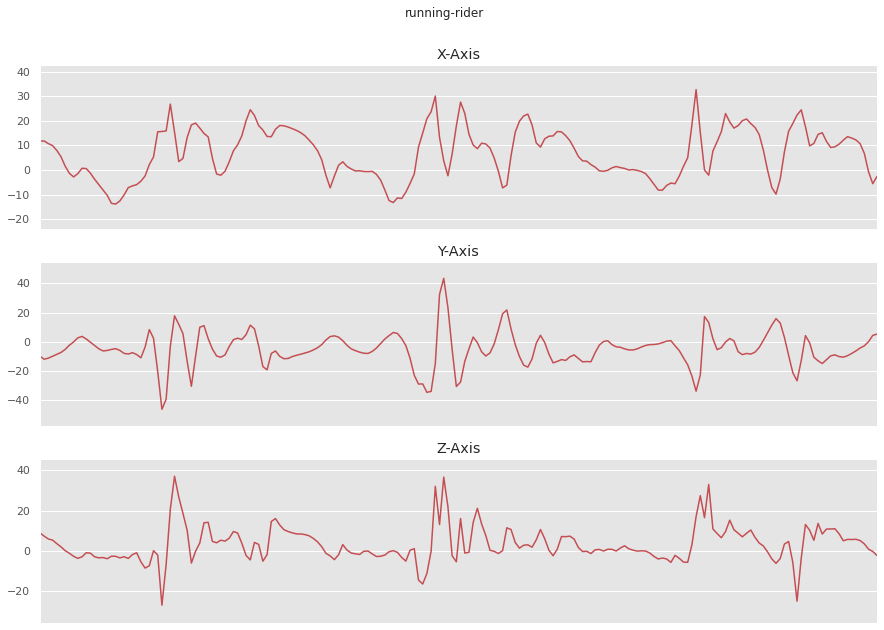

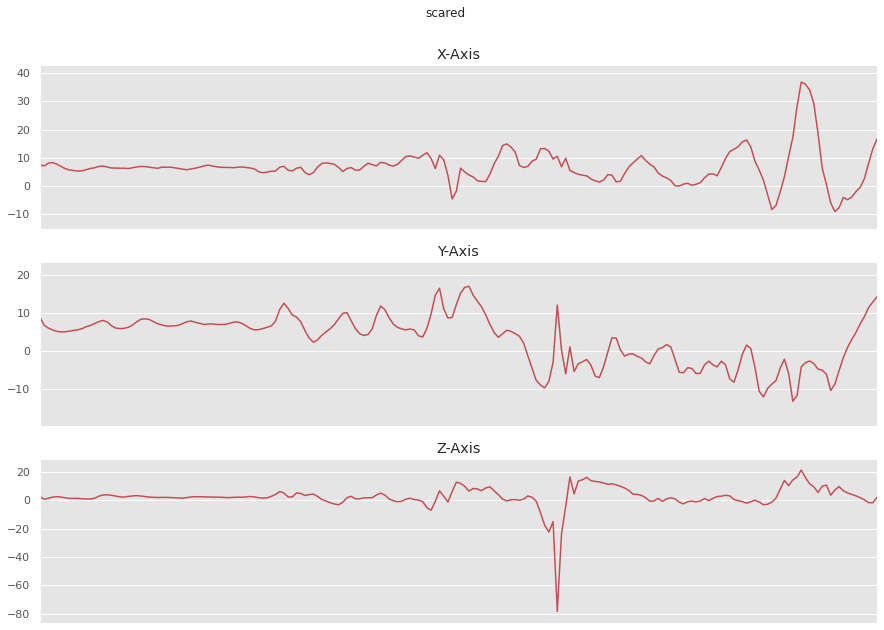

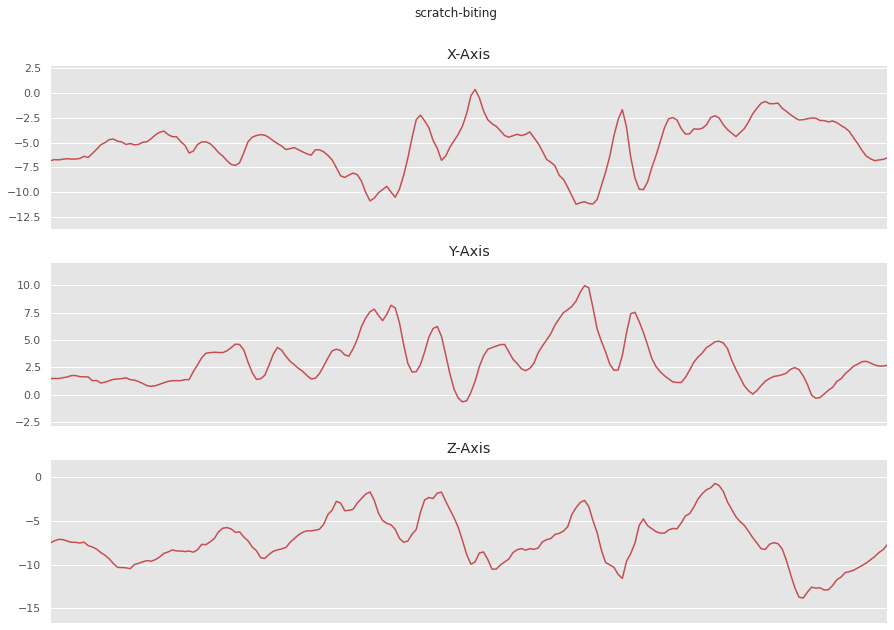

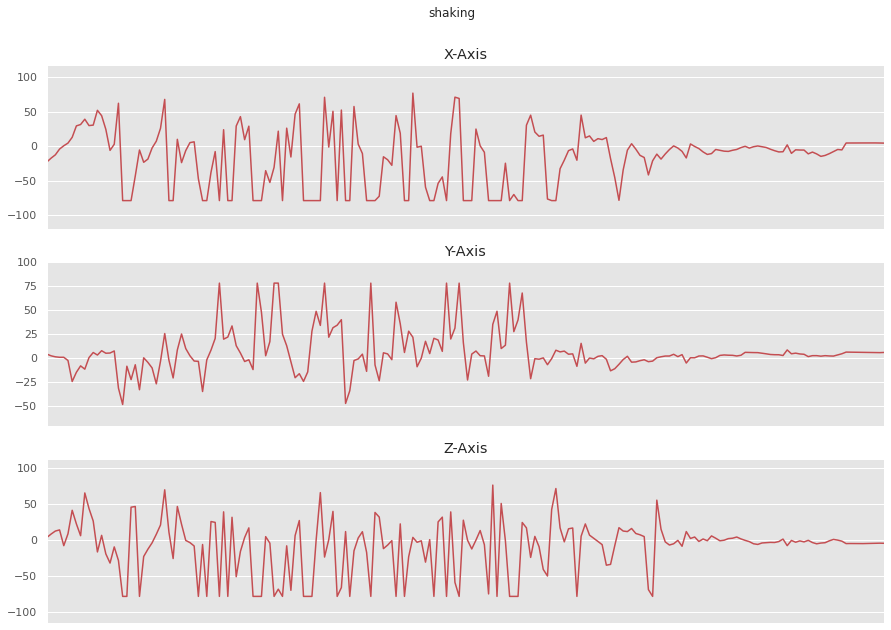

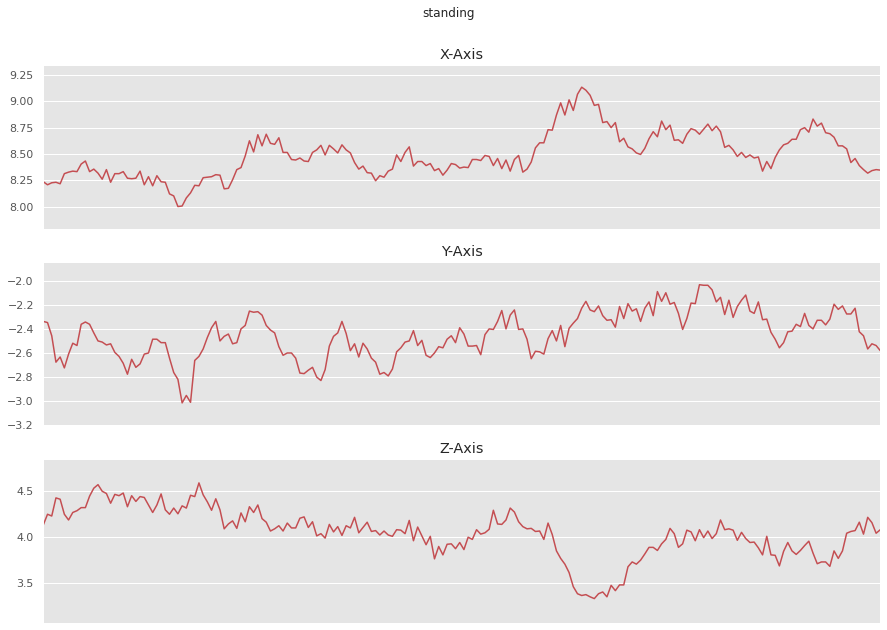

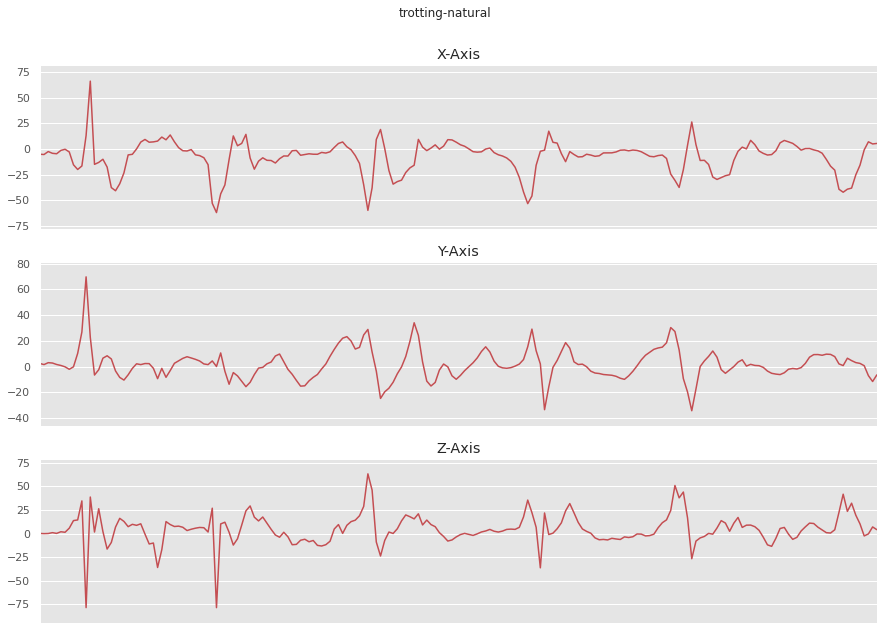

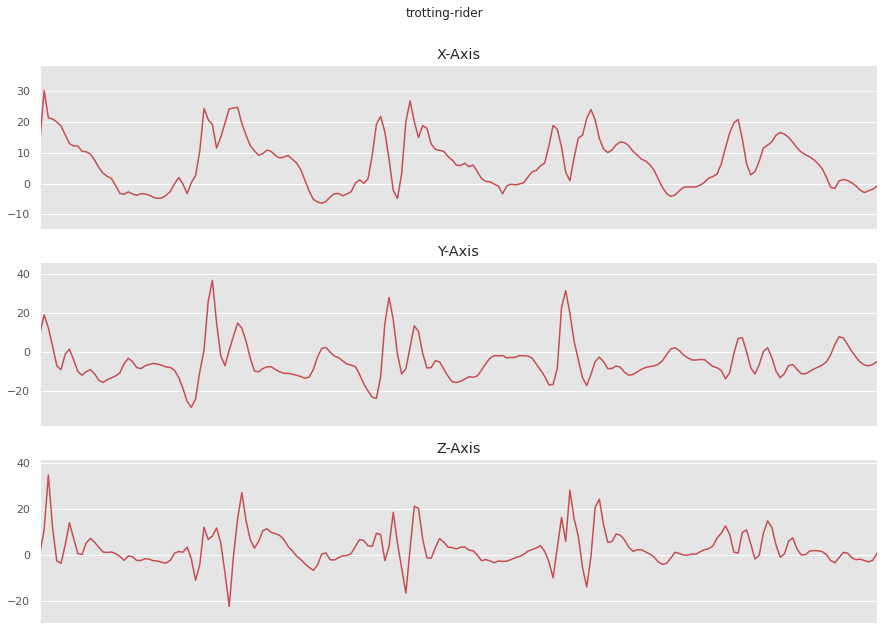

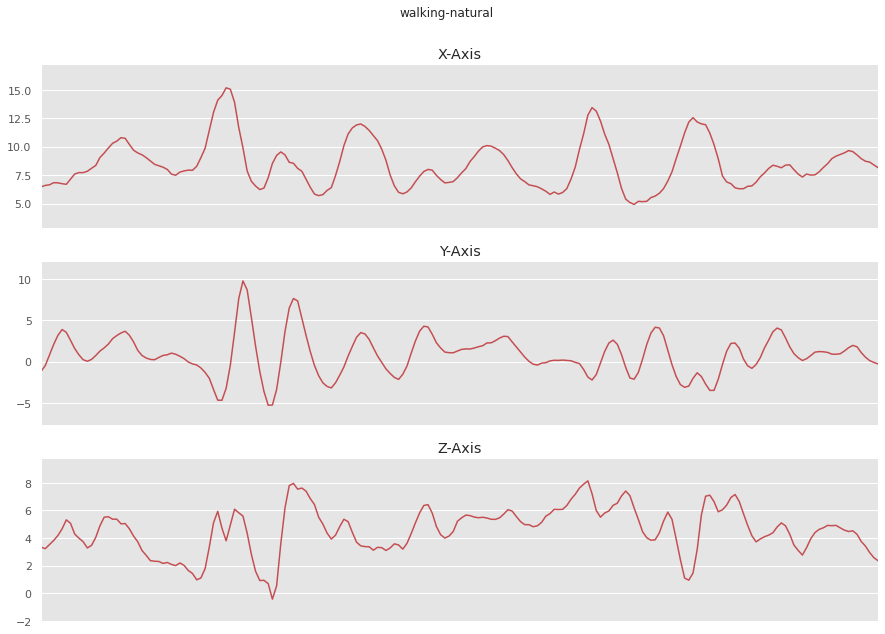

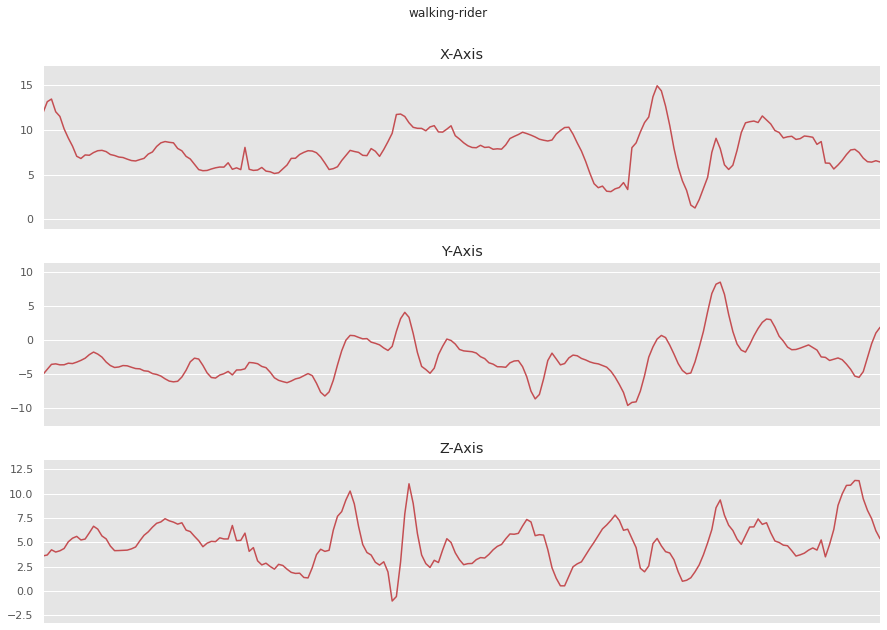

In [7]:
#Training examples per activity type
df['label'].value_counts().plot(kind='bar', title='Training Examples of subject Viva by Activity Type')
plt.show()

SECONDS = 10 #nr of seconds to display accelerometer data
SAMPLING_RATE = 20 #the sampling rate at which data was recorded

def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, data['datetime'], data['Ax'], 'X-Axis')
    plot_axis(ax1, data['datetime'], data['Ay'], 'Y-Axis')
    plot_axis(ax2, data['datetime'], data['Az'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

#plot all 3 subplots for each activity
for activity in np.unique(df['label']):
    subset = df[df['label'] == activity][:SECONDS*SAMPLING_RATE] 
    pot_activity(activity, subset)


#Split training and test set

In [8]:
#Shuffles and splits the data into a training set of 80% of the data and a test set containing the other 20%
train, test = skl.model_selection.train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

#Apply feature scaling

In [52]:
#divide all 3 axis with the max value in the training set
train['Ax'] = train['Ax'] / train['Ax'].max()
train['Ay'] = train['Ay'] / train['Ay'].max()
train['Az'] = train['Az'] / train['Az'].max()

#divide all 3 axis with the max value in the training set
test['Ax'] = train['Ax'] / train['Ax'].max()
test['Ay'] = train['Ay'] / train['Ay'].max()
test['Az'] = train['Az'] / train['Az'].max()

# Round numbers up to 5 decimal spaces
train = train.round({'Ax': 5, 'Ay': 5, 'Az': 5})
test = test.round({'Ax': 5, 'Ay': 5, 'Az': 5})

<ipython-input-52-d859fd62b8d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Ax'] = train['Ax'] / train['Ax'].max()
<ipython-input-52-d859fd62b8d1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Ay'] = train['Ay'] / train['Ay'].max()
<ipython-input-52-d859fd62b8d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

ValueError: cannot reindex from a duplicate axis

#Segmentation of data (Sliding windows)

In [ ]:
LABEL = 'ActivityEncoded'

def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['Ax'].values[i: i + time_steps]
        ys = df['Ay'].values[i: i + time_steps]
        zs = df['Az'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(train, TIME_PERIODS, STEP_DISTANCE, LABEL)
x_test, y_test = create_segments_and_labels(test, TIME_PERIODS, STEP_DISTANCE, LABEL)

#set dimension of input and output
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size

#Flatten data to one dimension

In [ ]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
x_test = x_test.reshape(x_test.shape[0], input_shape)

# Apply One-Hot encoding

In [ ]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)